In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [22]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', creation_time=1667051792392, experiment_id='1', last_update_time=1667051792392, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [23]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [24]:
# !pip install pyarrow

In [25]:
# !pip install fastparquet

In [26]:
def prepare_df(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
        df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
        
    df['duration'] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)
    df = df.loc[(df['duration']>=1) & (df['duration']<=60),:]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df
    
        

In [27]:
df_train = prepare_df('./data/green_tripdata_2022-01.parquet')
df_val = prepare_df('./data/green_tripdata_2022-02.parquet')

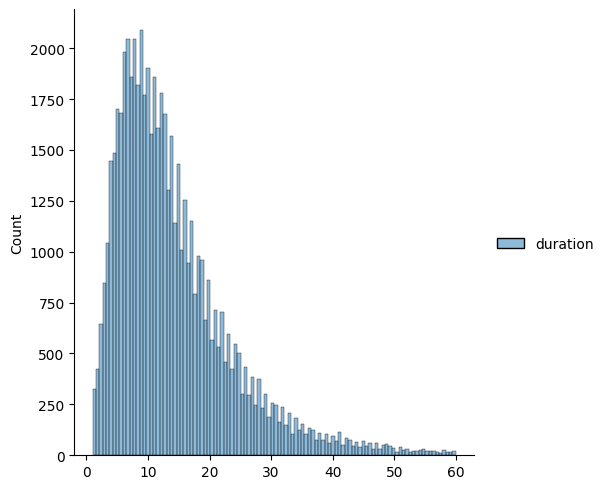

In [28]:
# Exploratory analysis

sns.displot(df_train.loc[((df_train['duration']>=1) & (df_train['duration']<=60)), ['duration']])

In [29]:
len(df_train), len(df_val)

(59603, 66097)

In [30]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59603 entries, 0 to 62494
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               59603 non-null  int64         
 1   lpep_pickup_datetime   59603 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  59603 non-null  datetime64[ns]
 3   store_and_fwd_flag     53367 non-null  object        
 4   RatecodeID             53367 non-null  float64       
 5   PULocationID           59603 non-null  object        
 6   DOLocationID           59603 non-null  object        
 7   passenger_count        53367 non-null  float64       
 8   trip_distance          59603 non-null  float64       
 9   fare_amount            59603 non-null  float64       
 10  extra                  59603 non-null  float64       
 11  mta_tax                59603 non-null  float64       
 12  tip_amount             59603 non-null  float64       
 13  t

In [32]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [33]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)


6.92893123431991

In [35]:
lr = Lasso(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# Estimate RMSE
mean_squared_error(y_val, y_pred, squared = False)

7.475775217343405

In [36]:
import pickle

with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [37]:
lr = Ridge(0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

9.987741338419413

### mlflow lesso regression exp-tracking

In [38]:
with mlflow.start_run():
    
    mlflow.set_tag('developer', 'Rahul')
    mlflow.log_param('train-data-path', './data/green_tripdata_2022-01.parquet')
    mlflow.log_param('val-data-path', './data/green_tripdata_2022-02.parquet')
    
    alpha = 0.3
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.log_artifact(local_path="./models/lin_reg.bin", artifact_path='models_pickle')
    
    

In [39]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [40]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [41]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 200,
            evals = [(valid, 'validation')],
            early_stopping_rounds = 50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    return {'loss': rmse, 'status': STATUS_OK}



In [42]:


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 10,
    trials = Trials()
)


[19:50:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:11.63566                          
[1]	validation-rmse:8.62715                           
[2]	validation-rmse:7.19473                           
[3]	validation-rmse:6.55118                           
[4]	validation-rmse:6.26162                           
[5]	validation-rmse:6.12645                           
[6]	validation-rmse:6.05392                           
[7]	validation-rmse:6.01791                           
[8]	validation-rmse:5.99405                           
[9]	validation-rmse:5.97862                           
[10]	validation-rmse:5.96251                          
[11]	validation-rmse:5.95858                          
[12]	validation-rmse:5.94594                          
[13]	validation-rmse:5.94423                          
[14]	validation-rmse:5.94380                          
[15]	validation-rmse:5.93953                          
[